In [67]:
# ==========================================
# PHASE 4: CODE DEMO
# Project: Sleep Efficiency Analysis and Prediction
# Group Members: Tyler Lafond, Michael Trbovic, Murede Adetiba, Jakub Drotlef
# Course: DS 3000
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
import xgboost as xgb

# Load Dataset
df = pd.read_csv('Sleep_Efficiency.csv')
print("Dataset Loaded. Shape:", df.shape)

# Handling Missing Values
# Fill numerical NaNs with mean/median, categorical with mode
df['Awakenings'] = df['Awakenings'].fillna(df['Awakenings'].median())
df['Caffeine consumption'] = df['Caffeine consumption'].fillna(0) # Assuming NaN means 0
df['Alcohol consumption'] = df['Alcohol consumption'].fillna(0)
df['Exercise frequency'] = df['Exercise frequency'].fillna(0)
# Drop ID column
df = df.drop('ID', axis=1)

# One-hot encode 'smoking status' and 'Gender'
df = pd.get_dummies(df, columns=['Gender', 'Smoking status'], drop_first=True)

# For simplicity in this demo, we will drop specific timestamps and rely on 'Sleep duration'
cols_to_drop = ['Bedtime', 'Wakeup time']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

display(df.head())

Dataset Loaded. Shape: (452, 15)


,Age,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Exercise frequency,Gender_Male,Smoking status_Yes
0,65,6.0,0.88,18,70,12,0.0,0.0,0.0,3.0,False,True
1,69,7.0,0.66,19,28,53,3.0,0.0,3.0,3.0,True,True
2,40,8.0,0.89,20,70,10,1.0,0.0,0.0,3.0,False,False
3,40,6.0,0.51,23,25,52,3.0,50.0,5.0,1.0,False,True
4,57,8.0,0.76,27,55,18,3.0,0.0,3.0,3.0,True,False


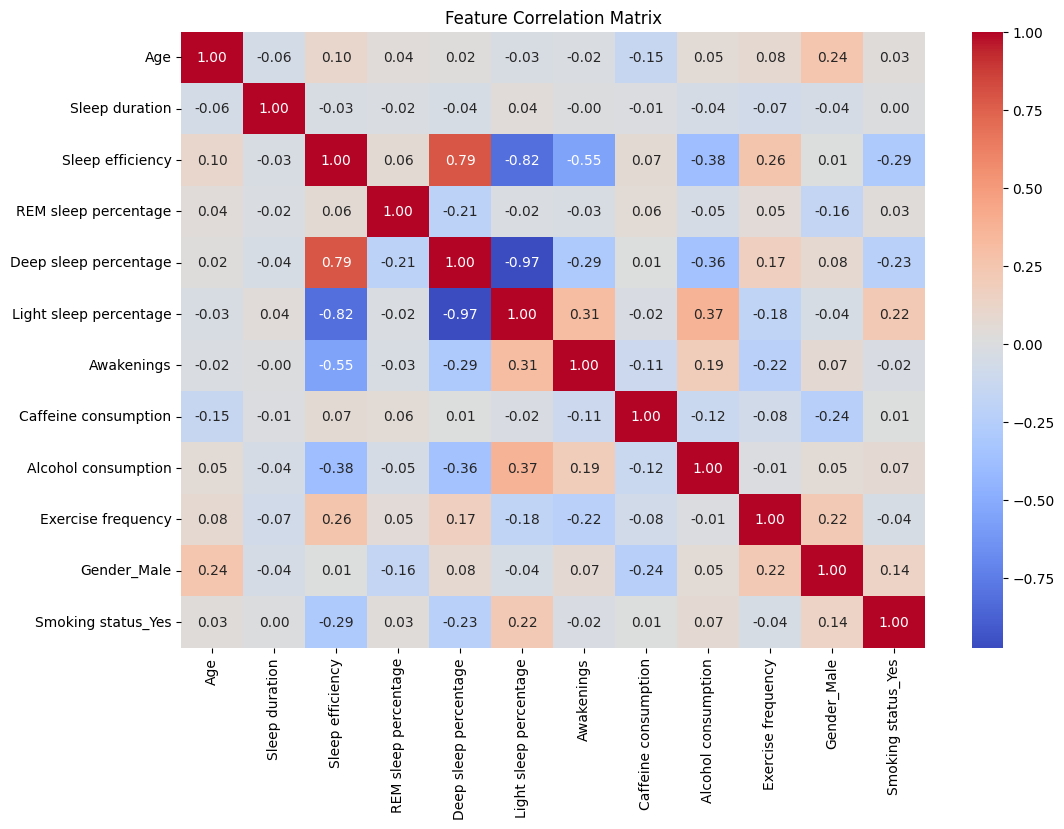

In [68]:
# Exploratory Data Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [69]:
# REGRESSION ANALYSIS
# Goal: Predict exact 'Sleep efficiency' (Continuous)

# Defining X and y
target = 'Sleep efficiency'
X = df.drop(target, axis=1)
y = df[target]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Models dictionary
reg_models = {
    "Linear Regression": LinearRegression(),
    "Lasso (L1 Regularization)": Lasso(alpha=0.001),
    "Random Forest": RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    "Neural Network (MLP)": MLPRegressor(
        hidden_layer_sizes=(50, 100),
        activation='tanh',
        solver='sgd',
        learning_rate_init=0.1,
        max_iter=100,
        random_state=42)
}

# Training and Evaluation
reg_results = []

print(f"{'Model':<25} | {'RMSE':<10} | {'MAE':<10} | {'R2 Score':<10}")
print("-" * 65)

for name, model in reg_models.items():
    # Use scaled data for Linear/Lasso/MLP, raw for Trees (though Trees handle unscaled fine)
    if name in ["Linear Regression", "Lasso (L1 Regularization)", "Neural Network (MLP)"]:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    reg_results.append([name, rmse, mae, r2])
    print(f"{name:<25} | {rmse:<10.4f} | {mae:<10.4f} | {r2:<10.4f}")

Model                     | RMSE       | MAE        | R2 Score  
-----------------------------------------------------------------
Linear Regression         | 0.0621     | 0.0507     | 0.7930    
Lasso (L1 Regularization) | 0.0622     | 0.0510     | 0.7919    
Random Forest             | 0.0515     | 0.0384     | 0.8578    
XGBoost                   | 0.0570     | 0.0425     | 0.8256    
Neural Network (MLP)      | 0.0679     | 0.0555     | 0.7522    


Model                     | Accuracy   | CV Mean Acc
------------------------------------------------------------
Logistic Regression       | 0.9121     | 0.8753    
KNN (k=5)                 | 0.8571     | 0.8144    
SVM (RBF Kernel)          | 0.9231     | 0.8892    
Random Forest Clf         | 0.9341     | 0.8865    


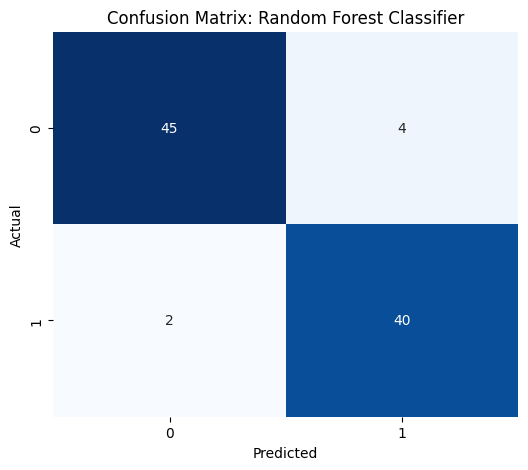

In [7]:
# CLASSIFICATION ANALYSIS
# Goal: Predict 'High' vs 'Low' Efficiency (Categorical)

# Discretizing Target
# Threshold: 0.85 (High Efficiency = 1, Low = 0)
threshold = 0.85
y_class = (y > threshold).astype(int)

# Split for classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scale features (re-using scaler)
X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)

class_models = {
    "Logistic Regression": LogisticRegression(),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF Kernel)": SVC(kernel='rbf'),
    "Random Forest Clf": RandomForestClassifier(n_estimators=100, random_state=42)
}

# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"{'Model':<25} | {'Accuracy':<10} | {'CV Mean Acc':<10}")
print("-" * 60)

for name, model in class_models.items():
    # Train on full training set
    model.fit(X_train_c_scaled, y_train_c)
    preds_c = model.predict(X_test_c_scaled)

    # Metrics
    acc = accuracy_score(y_test_c, preds_c)

    # Cross Validation
    cv_results = cross_val_score(model, X_train_c_scaled, y_train_c, cv=kfold, scoring='accuracy')

    print(f"{name:<25} | {acc:<10.4f} | {cv_results.mean():<10.4f}")

# Confusion Matrix for Random Forest
rf_clf = class_models["Random Forest Clf"]
y_pred_rf = rf_clf.predict(X_test_c_scaled)
cm = confusion_matrix(y_test_c, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Random Forest Classifier')
plt.show()

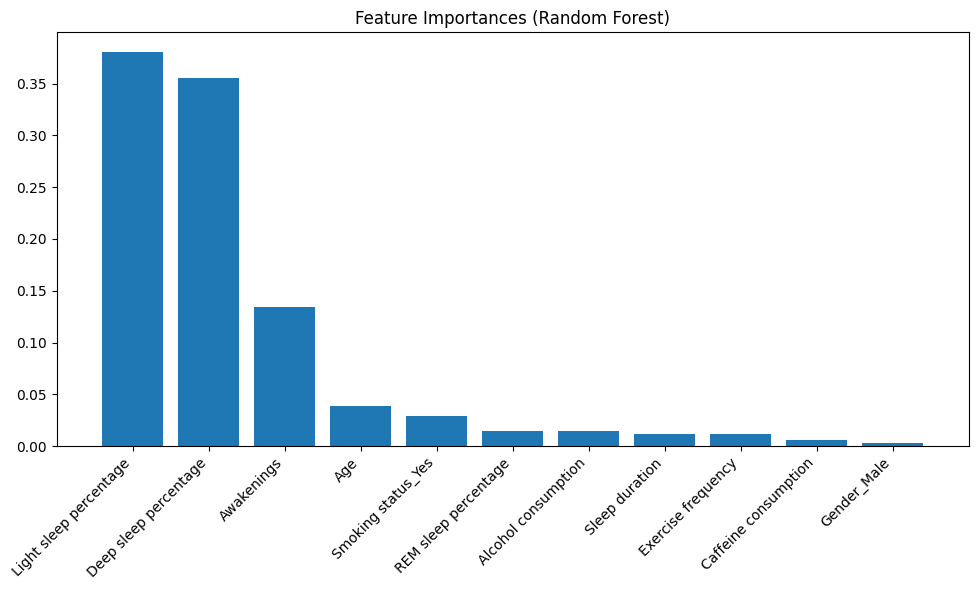

Top 3 Predictive Features:
1. Light sleep percentage (0.3804)
2. Deep sleep percentage (0.3552)
3. Awakenings (0.1344)


In [8]:
# Sleep Efficiency FEATURE IMPORTANCE

# Using the Random Forest Regressor from earlier regression analysis
rf_reg = reg_models["Random Forest"]
importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45, ha='right')
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

# Print top 3 features
print("Top 3 Predictive Features:")
for i in range(3):
    print(f"{i+1}. {X.columns[indices[i]]} ({importances[indices[i]]:.4f})")

All the models have an easy time prediciting sleep efficiency, this is likley due to multicolinearity with deep sleep percentage and a high negative correlation with light sleep percentage. Lets drop these and try again.

Model                     | RMSE       | MAE        | R2 Score  
-----------------------------------------------------------------
Linear Regression         | 0.0949     | 0.0747     | 0.5160    
Lasso (L1 Regularization) | 0.0954     | 0.0751     | 0.5116    
Random Forest             | 0.0790     | 0.0601     | 0.6648    
XGBoost                   | 0.0836     | 0.0637     | 0.6247    
Neural Network (MLP)      | 0.0867     | 0.0693     | 0.5960    


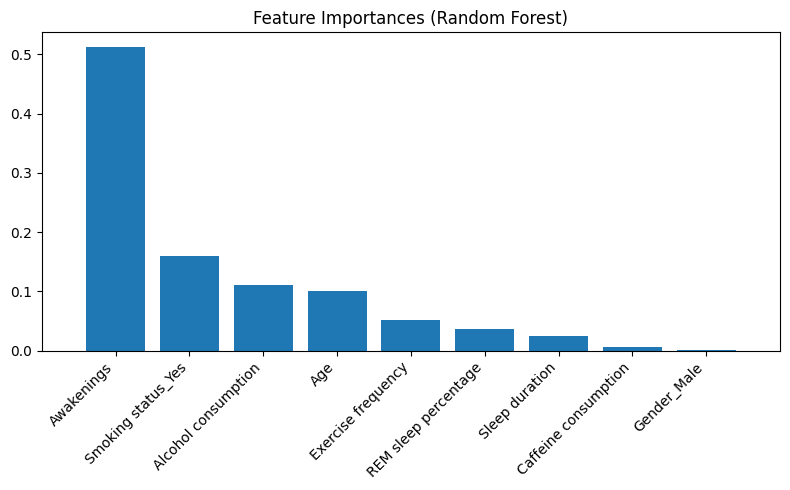

Top 3 Predictive Features:
1. Awakenings (0.5115)
2. Smoking status_Yes (0.1599)
3. Alcohol consumption (0.1100)


In [70]:
# REGRESSION ANALYSIS (without deep/light sleep percentages)

# Defining X and y
target = 'Sleep efficiency'
X = df.drop([target, 'Deep sleep percentage', 'Light sleep percentage'], axis=1)
y = df[target]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Models dictionary
reg_models = {
    "Linear Regression": LinearRegression(),
    "Lasso (L1 Regularization)": Lasso(alpha=0.001),
    "Random Forest": RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    "Neural Network (MLP)": MLPRegressor(
        hidden_layer_sizes=(50, 100),
        activation='tanh',
        solver='sgd',
        learning_rate_init=0.1,
        max_iter=100,
        random_state=42)
}

# Training and Evaluation
reg_results = []

print(f"{'Model':<25} | {'RMSE':<10} | {'MAE':<10} | {'R2 Score':<10}")
print("-" * 65)

for name, model in reg_models.items():
    # Use scaled data for Linear/Lasso/MLP, raw for Trees (though Trees handle unscaled fine)
    if name in ["Linear Regression", "Lasso (L1 Regularization)", "Neural Network (MLP)"]:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    reg_results.append([name, rmse, mae, r2])
    print(f"{name:<25} | {rmse:<10.4f} | {mae:<10.4f} | {r2:<10.4f}")

# Sleep Efficiency Feature importance

# Using the Random Forest Regressor from earlier regression analysis
rf_reg = reg_models["Random Forest"]
importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45, ha='right')
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

# Print top 3 features
print("Top 3 Predictive Features:")
for i in range(3):
    print(f"{i+1}. {X.columns[indices[i]]} ({importances[indices[i]]:.4f})")

Looks like the main factor affecting sleep efficiency is the number of awakenings, followed further behind by smoking, alcohol consumption, and age.

Random Forest seems to be handling this the best with the lowest errors and highest R^2, Lets use this model to determine the main drivers behind higher deep sleep percentage or light sleep percentage.


DEEP SLEEP
Model                     | RMSE       | MAE        | R2 Score  
-----------------------------------------------------------------
Random Forest (Deep Sleep)  | 11.3898    | 7.5543     | 0.4688    


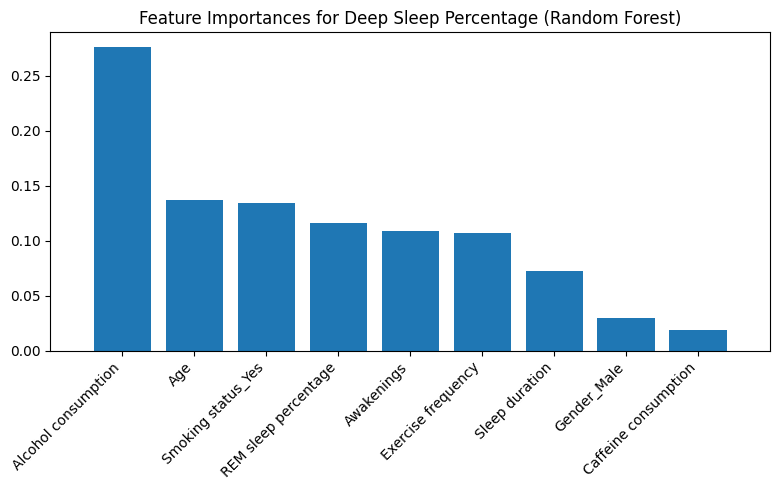

Top 3 Predictive Features for Deep Sleep Percentage:
1. Alcohol consumption (0.2757)
2. Age (0.1372)
3. Smoking status_Yes (0.1338)


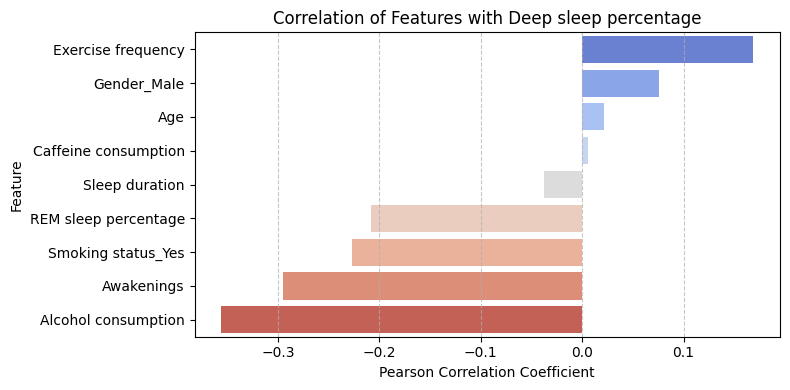

In [71]:
# REGRESSION ANALYSIS with respect to Deep sleep percentage

# Drop 'Deep/Light sleep percentage' and 'Sleep efficiency' from features as it's highly correlated
# and might introduce multicollinearity or be too direct of a predictor for 'Light or Deep sleep percentage' respectively.

# Defining X and y for 'Deep sleep percentage'
X_ds = df.drop(['Deep sleep percentage', 'Sleep efficiency', 'Light sleep percentage'], axis=1, errors='ignore')
y_ds = df['Deep sleep percentage']

# Train/Test Split
# deep sleep
X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(X_ds, y_ds, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_ds_scaled = scaler.fit_transform(X_train_ds)
X_test_ds_scaled = scaler.transform(X_test_ds)

# Training and Evaluation for Deep Sleep Percentage
print("\nDEEP SLEEP")
print(f"{'Model':<25} | {'RMSE':<10} | {'MAE':<10} | {'R2 Score':<10}")
print("-" * 65)

# Re-use the rf_reg from the previous regression analysis (or redefine if needed)
rf_reg = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)

rf_reg.fit(X_train_ds_scaled, y_train_ds)
preds_ds = rf_reg.predict(X_test_ds_scaled)

rmse_ds = np.sqrt(mean_squared_error(y_test_ds, preds_ds))
mae_ds = mean_absolute_error(y_test_ds, preds_ds)
r2_ds = r2_score(y_test_ds, preds_ds)
print(f"Random Forest (Deep Sleep)  | {rmse_ds:<10.4f} | {mae_ds:<10.4f} | {r2_ds:<10.4f}")

# Feature Importances for Deep Sleep Percentage using Random Forest
importances_ds = rf_reg.feature_importances_
indices_ds = np.argsort(importances_ds)[::-1]

plt.figure(figsize=(8, 5))
plt.title("Feature Importances for Deep Sleep Percentage (Random Forest)")
plt.bar(range(X_ds.shape[1]), importances_ds[indices_ds], align="center")
plt.xticks(range(X_ds.shape[1]), X_ds.columns[indices_ds], rotation=45, ha='right')
plt.xlim([-1, X_ds.shape[1]])
plt.tight_layout()
plt.show()

print("Top 3 Predictive Features for Deep Sleep Percentage:")
for i in range(min(3, X_ds.shape[1])):
    print(f"{i+1}. {X_ds.columns[indices_ds[i]]} ({importances_ds[indices_ds[i]]:.4f})")

target_variable = 'Deep sleep percentage'

df_for_corr = X_ds.copy()
df_for_corr[target_variable] = y_ds

# Calculate correlations, excluding the target variable itself from the feature list
correlations = df_for_corr.corr()[target_variable].drop(target_variable)
correlations_sorted = correlations.sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=correlations_sorted.values, y=correlations_sorted.index, palette='coolwarm', hue=correlations_sorted.index, legend=False)
plt.title(f'Correlation of Features with {target_variable}')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()